In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
import datetime as dt
from tensorflow import keras

In [ ]:
!pip install mediapy

In [ ]:
import mediapy

In [3]:
IMAGE_HEIGHT, IMAGE_WIDTH = 124, 124

SEQUENCE_LENGTH = 24

DATASET_DIR = "/kaggle/input/fall-detection-v4/fall-detection"

CLASSES_LIST = ["falls", "nofalls"]

In [4]:
def frames_extraction(video_path):
    frames_list = []
    
    video_reader = cv2.VideoCapture(video_path)
    print(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    print(video_frames_count)
    skip_frames_window = max(video_frames_count/SEQUENCE_LENGTH, 1)
    
    for frame_counter in range(SEQUENCE_LENGTH):
        
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, int(frame_counter * skip_frames_window))
        success, frame = video_reader.read()
        
        if not success:
            break
            
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        frames_list.append(resized_frame)
        
    video_reader.release()
    
    return frames_list

In [5]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        
        print(f'Extracting data of class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            
                video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
                frames = frames_extraction(video_file_path)
                print(len(frames))
                
                if len(frames) == SEQUENCE_LENGTH:
                    
                    features.append(frames)
                    labels.append(1 - class_index)
                    video_files_paths.append(video_file_path)
                    
    features = np.asarray(features)
    labels = np.array(labels)
    
    return features, labels, video_files_paths

In [6]:
features, labels, video_files_paths = create_dataset()

Extracting data of class: falls
/kaggle/input/fall-detection-v4/fall-detection/falls/fall93.avi
36
24
/kaggle/input/fall-detection-v4/fall-detection/falls/fall10.avi
36
24
/kaggle/input/fall-detection-v4/fall-detection/falls/fall6.mov
57
24
/kaggle/input/fall-detection-v4/fall-detection/falls/fall62.avi
36
24
/kaggle/input/fall-detection-v4/fall-detection/falls/fall82.avi
36
24
/kaggle/input/fall-detection-v4/fall-detection/falls/fall105.avi
36
24
/kaggle/input/fall-detection-v4/fall-detection/falls/fall40.avi
36
24
/kaggle/input/fall-detection-v4/fall-detection/falls/fall35.avi
36
24
/kaggle/input/fall-detection-v4/fall-detection/falls/fall11.avi
36
24
/kaggle/input/fall-detection-v4/fall-detection/falls/fall6.avi
36
24
/kaggle/input/fall-detection-v4/fall-detection/falls/fall165.avi
36
24
/kaggle/input/fall-detection-v4/fall-detection/falls/fall123.avi
36
24
/kaggle/input/fall-detection-v4/fall-detection/falls/fall134.avi
36
24
/kaggle/input/fall-detection-v4/fall-detection/falls/fal

In [7]:
labels[0] = 1

In [ ]:
mediapy.show_video(features[0], title=labels[0], fps=5, width=300)

In [ ]:
video_path = '/kaggle/input/fall-detection/fall-detection/falls/fall93.avi'

video = mediapy.read_video(video_path)
mediapy.show_video(video,  width=300, height=300, fps=10)

In [10]:
x_train, x_val, y_train, y_val = train_test_split(features, labels, test_size = 0.2,
                                                                            shuffle = True)

In [11]:
num_classes = 2
input_shape = (SEQUENCE_LENGTH, 124, 124, 3)

In [12]:
def create_model(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    
    model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    
    model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D((2, 2, 2)))

    model.add(BatchNormalization())

    model.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D((2, 2, 2)))

    model.add(BatchNormalization())

    model.add(Conv3D(256, (3, 3, 3), activation='relu', padding='same'))
    model.add(MaxPooling3D((2, 2, 2)))
    
    model.add(BatchNormalization())

    model.add(Flatten())
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss="BinaryCrossentropy", metrics=['accuracy', 'precision'])
    
    return model

In [13]:
# Define the shape of input frames and create the advanced 3D CNN model
model = create_model(input_shape, num_classes)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                 │ (None, 24, 124, 124,   │         2,624 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 24, 124, 124,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 24, 124, 124,   │        27,680 │
│                                 │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 124, 124,   │           128 │
│ (BatchNormalization)            │ 32)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_2 (Conv3D)               │ (None, 24, 124, 124,   │        55,360 │
│                                 │ 64)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 12, 62, 62, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 62, 62, 64) │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_3 (Conv3D)               │ (None, 12, 62, 62,     │       221,312 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 6, 31, 31, 128) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 31, 31, 128) │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_4 (Conv3D)               │ (None, 6, 31, 31, 256) │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 3, 15, 15, 256) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 15, 15, 256) │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 172800)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    88,474,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,799,713 (342.56 MB)

 Trainable params: 89,798,689 (342.55 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file="model_structure_plot.png", show_shapes=True, show_layer_names=True)

In [14]:
early_stopping_callback = EarlyStopping(monitor="val_loss", patience=20, mode="min", restore_best_weights=True)

In [15]:
mode_training_history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=80, batch_size=8,
                    callbacks=[early_stopping_callback])

Epoch 1/80


2024-10-21 22:49:54.568497: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[32,32,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,24,124,124]{4,3,2,1,0}, f32[8,32,24,124,124]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-10-21 22:49:58.242573: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 4.674244852s
Trying algorithm eng0{} for conv (f32[32,32,3,3,3]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,24,124,124]{4,3,2,1,0}, f32[8,32,24,124,124]{4,3,2,1,0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while.

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step - accuracy: 0.4915 - loss: 19.3033 - precision: 0.4534

W0000 00:00:1729551056.345775    1665 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1729551063.299774    1664 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


39/39 ━━━━━━━━━━━━━━━━━━━━ 97s 715ms/step - accuracy: 0.4924 - loss: 19.2751 - precision: 0.4547 - val_accuracy: 0.5513 - val_loss: 251.6292 - val_precision: 0.5513
Epoch 2/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 518ms/step - accuracy: 0.5653 - loss: 11.3868 - precision: 0.5673 - val_accuracy: 0.5513 - val_loss: 3059.0654 - val_precision: 0.5513
Epoch 3/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 517ms/step - accuracy: 0.6015 - loss: 10.6172 - precision: 0.5781 - val_accuracy: 0.4615 - val_loss: 449.4837 - val_precision: 1.0000
Epoch 4/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 526ms/step - accuracy: 0.6159 - loss: 7.2225 - precision: 0.6238 - val_accuracy: 0.7308 - val_loss: 33.6799 - val_precision: 0.9583
Epoch 5/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 523ms/step - accuracy: 0.7398 - loss: 2.8455 - precision: 0.7445 - val_accuracy: 0.7051 - val_loss: 8.9448 - val_precision: 0.9167
Epoch 6/80
39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 522ms/step - accuracy: 0.7724 - loss: 3.4009 - precision: 0.8032 - val_accuracy: 0.5769 - val

In [16]:
model_evaluation_history = model.evaluate(x_val, y_val)

2024-10-21 23:07:16.966947: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=4,k3=0} for conv (f32[32,64,24,124,124]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,24,124,124]{4,3,2,1,0}, f32[64,32,3,3,3]{4,3,2,1,0}, f32[64]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-10-21 23:07:17.538526: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.571680137s
Trying algorithm eng11{k2=4,k3=0} for conv (f32[32,64,24,124,124]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,24,124,124]{4,3,2,1,0}, f32[64,32,3,3,3]{4,3,2,1,0}, f32[64]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.7344 - loss: 0.5284 - precision: 0.9129

2024-10-21 23:07:36.573812: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng11{k2=1,k3=0} for conv (f32[14,64,24,124,124]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[14,32,24,124,124]{4,3,2,1,0}, f32[64,32,3,3,3]{4,3,2,1,0}, f32[64]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-10-21 23:07:36.689520: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.115821285s
Trying algorithm eng11{k2=1,k3=0} for conv (f32[14,64,24,124,124]{4,3,2,1,0}, u8[0]{0}) custom-call(f32[14,32,24,124,124]{4,3,2,1,0}, f32[64,32,3,3,3]{4,3,2,1,0}, f32[64]{0}), window={size=3x3x3 pad=1_1x1_1x1_1}, dim_labels=bf012_oi012->bf012, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu

3/3 ━━━━━━━━━━━━━━━━━━━━ 34s 6s/step - accuracy: 0.7454 - loss: 0.5070 - precision: 0.9207 


In [ ]:
date_time_format = "%Y_%m_%d_%H_%M_%S"
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'fall-detection_v2.h5'

model.save(model_file_name)

In [17]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))
    
    plt.plot(epochs, metric_value_1, "blue", label = metric_name_1)
    plt.plot(epochs, metric_value_2, "red", label = metric_name_2)
    
    plt.title(str(plot_name))
    
    plt.legend()

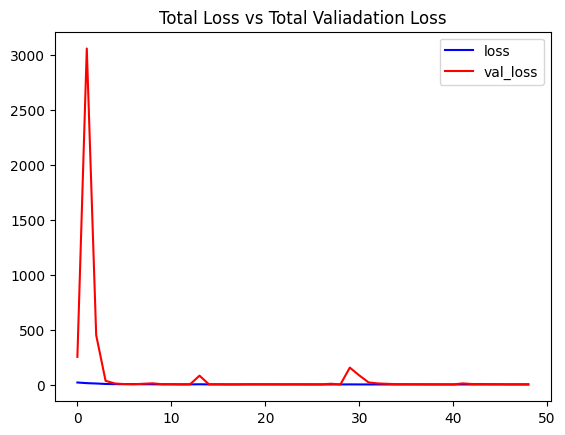

In [18]:
plot_metric(mode_training_history, "loss", "val_loss", "Total Loss vs Total Valiadation Loss")

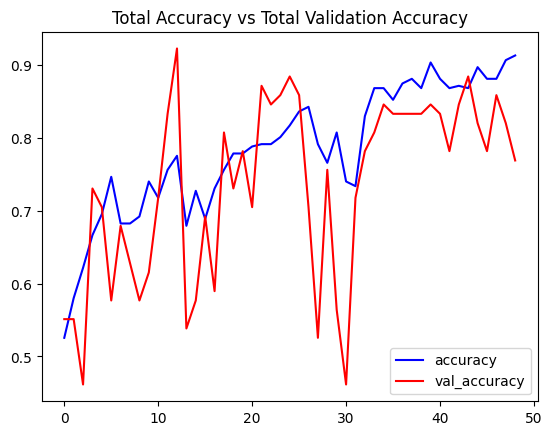

In [19]:
plot_metric(mode_training_history, "accuracy", "val_accuracy", "Total Accuracy vs Total Validation Accuracy")

In [ ]:
!pip install pafy

In [ ]:
!pip install youtube-dl

In [ ]:
import pafy
import moviepy as mp

In [ ]:
new_model = tf.keras.models.load_model('/kaggle/input/fall-detector-v2/tensorflow2/default/1/fall-detection_v2.h5')

In [ ]:
new_model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(new_model, to_file="model_structure_plot.png", show_shapes=True, show_layer_names=True)

In [ ]:
def predict_single_action(video_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)
    
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    frames_list = []
    predicted_class_name = ''
    
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(video_frames_count/SEQUENCE_LENGTH, 1)
    
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, int(frame_counter * skip_frames_window))
        
        success, frame = video_reader.read()
        
        if not success:
            break
        
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        frames_list.append(resized_frame)
        
    predicted_label_probabilities = new_model.predict(np.expand_dims(frames_list, axis = 0))
    
    # predicted_label = np.argmax(predicted_label_probabilities)
    
    if predicted_label_probabilities > .7:
        predicted_label = 0
    else:
        predicted_label = 1
    
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    print(f'Prediction: {predicted_class_name}\nValue: {predicted_label_probabilities}')
    
    video_reader.release()

In [ ]:
input_video_file_path = "/kaggle/input/fall-test4/fall4.mp4"

predict_single_action(input_video_file_path, SEQUENCE_LENGTH)